# Проведение оценки результатов A/B-теста, связанного с внедрением улучшенной рекомендательной системы

# *Краткое описание*

**Цели и задачи проекта:** 

1. Оценить корректность проведения теста.
2. Проанализировать результаты теста.

Для выполнения поставленной задачи предстоит работать с данными, содержащимися в четырех датасетах формата csv.

**План работы:**
1. Откроем файлы с данными, изучим общую информацию и предобработаем их.
2. Проведем исследовательский анализ данных.
3. Проведем оценку результатов A/B-тестирования.
4. Подготовим выводы исследования.

**Оглавление**

1. [Ознакомление с данными и предобработка](#start)
2. [Исследовательский анализ](#analyzing)
3. [Оценка результатов А/В-теста](#results_checking)
4. [Общие выводы](#summary)

**Техническое задание**
1. Название теста: recommender_system_test;
2. Группы: А (контрольная), B (новая платёжная воронка);
3. Дата запуска: 2020-12-07;
4. Дата остановки набора новых пользователей: 2020-12-21;
5. Дата остановки: 2021-01-04;
6. Аудитория: 15% новых пользователей из региона EU;
7. Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
8. Ожидаемое количество участников теста: 6000.
9. Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие product_page;
    - просмотры корзины — product_cart;
    - покупки — purchase.

<a id="start"></a>
## Ознакомление с данными и предобработка 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import math as mth

In [2]:
#сохраним данные в соответствующие переменные
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
ab_events = pd.read_csv('/datasets/final_ab_events.csv')
ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')

In [3]:
#создадим функцию для ознакомления с данными
def data_info(data):
    print('Визуальное ознакомление с датасетом')
    display(data.head())
    print()
    print('Получение информации о датасете')
    display(data.describe())
    print()
    display(data.info())
    print()
    print('Доля пропущенных значений')
    display(data.isna().mean()*100)  

### Датасет marketing_events

In [4]:
#посмотрим на датасет marketing_events
data_info(marketing_events)

Визуальное ознакомление с датасетом


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11



Получение информации о датасете


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Labor day (May 1st) Ads Campaign,APAC,2020-07-04,2020-05-11
freq,1,4,1,1



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes


None


Доля пропущенных значений


name         0.0
regions      0.0
start_dt     0.0
finish_dt    0.0
dtype: float64

In [5]:
#отсортируем даты завершения маркетинговых событий 
marketing_events.sort_values(by='finish_dt', ascending=False)

,name,regions,start_dt,finish_dt
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07
4,4th of July Promo,N.America,2020-07-04,2020-07-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19


In [6]:
#напишем функцию для проверки пересечения дат
def test_date(data):
    if data['start_dt'] > '2021-01-04' or data['finish_dt'] < '2020-12-07':
        return 'NO'
    elif 'EU' not in data['regions']:
        return 'NO'
    else:
        return 'YES'
#добавим столбец с указанием пересечений 
marketing_events['intersection'] = marketing_events.apply(test_date, axis=1)

In [7]:
#посмотрим на пересечения марк. событий и а/в теста
marketing_events

,name,regions,start_dt,finish_dt,intersection
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,YES
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16,NO
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19,NO
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19,NO
4,4th of July Promo,N.America,2020-07-04,2020-07-11,NO
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01,NO
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07,NO
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03,NO
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10,NO
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11,NO


**Выводы:**
1. В данном датасете представлены данные маркетинговых событий за 20 год. 
2. Тип данных во всех 4 столбцах - object. Данный тип данных можно оставить без изменений, т.к. для целей исследования он подходит. Пропусков и дубликатов нет.
3. Обращаем внимание на то, что для региона EU одно маркетинговое событие проходило в тоже время, что и А/В-тест: Christmas&New Year Promo с 25.12.20 по 03.01.21.

### Датасет ab_new_users

In [8]:
#посмотрим на датасет ab_new_users
data_info(ab_new_users)

Визуальное ознакомление с датасетом


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone



Получение информации о датасете


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,814EE158DDEE3B0A,2020-12-21,EU,Android
freq,1,6290,46270,27520



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


None


Доля пропущенных значений


user_id       0.0
first_date    0.0
region        0.0
device        0.0
dtype: float64

In [9]:
#приведем столбец с датой к типу date
ab_new_users['first_date'] = pd.to_datetime(ab_new_users['first_date'], format='%Y-%m-%d')

#проверяем
ab_new_users.info()
display(ab_new_users.head(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null datetime64[ns]
region        61733 non-null object
device        61733 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC


In [10]:
#посмотрим на минимальную и максимальную даты
print(f"Минимальная дата: {ab_new_users['first_date'].min()}.")
print(f"Максимальная дата: {ab_new_users['first_date'].max()}.")

Минимальная дата: 2020-12-07 00:00:00.
Максимальная дата: 2020-12-23 00:00:00.


*По заданию набор пользователей должен был быть остановлен 21.12.20, но в данных видим пользователей, которые зарегистрировались 23.12.20. Необходимо посчитать количество таких пользователей.* 

In [11]:
#посмотрим на строки, после 21.12.20
ab_new_users.query('first_date > "2020-12-21"').head()

#посчитаем их соотношение к общему объему датасета
print('Процент пользователей, пришедших после 21.12, от общего объема датасета: {:.2%}'.\
      format(len(ab_new_users.query('first_date > "2020-12-21"')) / len(ab_new_users)))

Процент пользователей, пришедших после 21.12, от общего объема датасета: 8.53%


In [12]:
#делаем срез только для тех, кто пришел до 21.12.20
ab_new_users_cleaned = ab_new_users.query('first_date <= "2020-12-21"').copy()

#проверяем
display(ab_new_users_cleaned.head())
print()
print(ab_new_users_cleaned['first_date'].max())
print()
ab_new_users_cleaned.info()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone



2020-12-21 00:00:00

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56470 entries, 0 to 61732
Data columns (total 4 columns):
user_id       56470 non-null object
first_date    56470 non-null datetime64[ns]
region        56470 non-null object
device        56470 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 2.2+ MB


In [13]:
#проверим на дубликаты
print(f'Количество дубликатов: {ab_new_users_cleaned.duplicated().sum()}.')

Количество дубликатов: 0.


In [14]:
#посмотрим на уникальные значения регионов
ab_new_users_cleaned['region'].value_counts()

EU           42340
N.America     8347
CIS           2900
APAC          2883
Name: region, dtype: int64

In [15]:
#создадим датасет для пользователей из EU
ab_new_users_cleaned_EU = ab_new_users_cleaned.query('region == "EU"').copy()

#проверяем
display(ab_new_users_cleaned_EU.head())
print()
ab_new_users_cleaned_EU.info()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
9,FFCEA1179C253104,2020-12-07,EU,Android



<class 'pandas.core.frame.DataFrame'>
Int64Index: 42340 entries, 0 to 61732
Data columns (total 4 columns):
user_id       42340 non-null object
first_date    42340 non-null datetime64[ns]
region        42340 non-null object
device        42340 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 1.6+ MB


**Выводы:**
1. В данном датасете представлены данные о пользователях, которых всего - 61 733.
2. По заданию набор пользователей должен был быть остановлен 21.12.20, но в данных есть пользователи, зарегистрировавшиеся 23.12.20. Поэтому создан срез ab_new_users_cleaned, в котором будут пользователи до 21.12.20. Также был создан дополнительный датасет для пользователей из региона EU - ab_new_users_cleaned_EU.  
3. Тип данных во всех 4 столбцах - object. В одном столбце хранятся сведения о дате, поэтому данный столбец привели к типу datetime. Остальные столбцы оставили без изменений, т.к. для целей исследования их тип менять не требуется.
4. Пропусков и дубликатов не обнаружено.

### Датасет ab_events

In [16]:
#посмотрим на датасет ab_events
data_info(ab_events)

Визуальное ознакомление с датасетом


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99



Получение информации о датасете


,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None


Доля пропущенных значений


user_id        0.000000
event_dt       0.000000
event_name     0.000000
details       85.751175
dtype: float64

*В столбце details почти 86 % пропусков. Далее необходимо изучить их. Кроме того, можем заметить, что в столбце event_dt хранятся даты, но тип данных object. Тип данных других столбцов оставляем без изменений.*

In [17]:
#посмотрим на уникальные значения столбца event_name  
ab_events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

*В столбце event_name предусмотрено 4 пользовательские события: ввод логина, страница продукта, покупки и корзина.*

In [18]:
#приведем столбец с датой к типу date
ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'], format='%Y-%m-%d %H:%M:%S')

#проверяем
ab_events.info()
display(ab_events.head(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null datetime64[ns]
event_name    440317 non-null object
details       62740 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99


In [19]:
#посмотрим на строки, у которых в столбце project_type NaN
display(ab_events.loc[ab_events['details'].isnull()].head())
display(ab_events.loc[ab_events['details'].isnull()].tail())
display(ab_events.loc[ab_events['details'].isnull()].info())

,user_id,event_dt,event_name,details
62740,2E1BF1D4C37EA01F,2020-12-07 09:05:47,product_cart,NaN
62741,50734A22C0C63768,2020-12-07 13:24:03,product_cart,NaN
62742,5EB159DA9DC94DBA,2020-12-07 22:54:02,product_cart,NaN
62743,084A22B980BA8169,2020-12-07 15:25:55,product_cart,NaN
62744,0FC21E6F8FAA8DEC,2020-12-07 06:56:27,product_cart,NaN


,user_id,event_dt,event_name,details
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN
440316,7AEC61159B672CC5,2020-12-30 11:36:13,login,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 377577 entries, 62740 to 440316
Data columns (total 4 columns):
user_id       377577 non-null object
event_dt      377577 non-null datetime64[ns]
event_name    377577 non-null object
details       0 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 14.4+ MB


None

*Наблюдаем следующее - пропуски имеются в строках details, если в столбце event_name любое событие кроме purchase. Дальше, чтобы убедиться в этом, посмотрим на общее количество строк, где значение details не NaN и при этом в столбце event_name значение purchase.*  

In [20]:
#смотрим на количество строк
len(ab_events.loc[ab_events['details'].notnull(), ['event_name']] == 'purchase')

62740

*Видим, что полученное количество равно количеству заполненных значений в details (62740). Следовательно, предположение выше верно. И делаем вывод, что details заполнялся только для покупок, чтобы отразить их стоимость. По этой причине с пропусками в столбце details делать ничего не будем.*

*Теперь необходимо проверить есть ли в датасете ab_events пользователи, которые пришли после 21.12.20*

In [21]:
#создаем списки id пользователей, которые пришли после 21.12.20
users_id_after_21 = list(ab_new_users.query('first_date > "2020-12-21"')['user_id'].unique())

#проверяем
ab_events.query('user_id in@users_id_after_21').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32567 entries, 44368 to 438417
Data columns (total 4 columns):
user_id       32567 non-null object
event_dt      32567 non-null datetime64[ns]
event_name    32567 non-null object
details       4647 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.2+ MB


*Как видим, в датасете ab_events тоже есть пользователи, которые пришли после 21.12.* 

In [22]:
#создаем датасет с теми, кто пришел до 21.12 включительно
ab_events_cleaned = ab_events.query('user_id not in@users_id_after_21').copy()

#проверяем
ab_events_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407750 entries, 0 to 440316
Data columns (total 4 columns):
user_id       407750 non-null object
event_dt      407750 non-null datetime64[ns]
event_name    407750 non-null object
details       58093 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 15.6+ MB


In [23]:
#проверим на дубликаты
print(f'Количество дубликатов: {ab_events_cleaned.duplicated().sum()}.')

Количество дубликатов: 0.


In [24]:
#посмотрим на даты событий
print(f"Минимальная дата {ab_events_cleaned['event_dt'].min()}, максимальная {ab_events_cleaned['event_dt'].max()}")

Минимальная дата 2020-12-07 00:00:33, максимальная 2020-12-30 23:36:33


*Даты укладываются в период, озвученный в задании. Поэтому исключать какие-либо строки не требуется. Но при этом отмечаем, что события перестали фиксироваться 30.12.20, а не 04.01.21 как планировалось.*

**Выводы:**
1. В данном датасете представлены данные о всех событиях пользователей.
2. В столбце details почти 86 % пропусков, однако столбец details заполнялся только для события - покупка, чтобы отразить его стоимость. По этой причине с пропусками в столбце details ничего не делали.
3. Создали датасет ab_events_cleaned, из которого убрали тех пользователей, которые пришли после 21.12.20. Кроме того заметили, что события перестали фиксироваться 30.12.20, а не 04.01.21 как планировалось.
4. Тип данных во всех 4 столбцах - object. В столбце event_dt хранятся сведения о дате и времени, поэтому данный столбец привели к типу datetime. Остальные столбцы оставили без изменений, т.к. для целей исследования их тип менять не требуется.
5. Дубликатов не обнаружено.

### Датасет ab_participants

In [25]:
#посмотрим на датасет ab_participants
data_info(ab_participants)

Визуальное ознакомление с датасетом


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test



Получение информации о датасете


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,28F165B39D160BC5,A,interface_eu_test
freq,2,9655,11567



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB


None


Доля пропущенных значений


user_id    0.0
group      0.0
ab_test    0.0
dtype: float64

In [26]:
#проверим уникальные значения в столбце с группами
ab_participants['group'].value_counts()

A    9655
B    8613
Name: group, dtype: int64

*В столбце содержатся только две группы: А и В. Каких-то дополнительных групп, в том числе записанных строчными буквами, нет.*

In [27]:
#проверим уникальные значения в столбце с названием теста
ab_participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

*В столбце имеется кроме интересующего нас теста еще и тест interface_eu_test. Посмотрим, есть ли пользователи, которые проходили и тот, и другой тест.*

In [28]:
#создаем списки id пользователей, которые входили тест. группу интерфейса
users_id_interface = list(ab_participants.query('ab_test == "interface_eu_test"')['user_id'].unique())

#проверяем на пересечение
len(ab_participants.query('user_id in@users_id_interface and ab_test == "recommender_system_test"')['user_id'].unique())

1602

*В переменной users_id_interface хранятся id пользователей, которые прошли тест interface_eu_test. Проверив на пересечение, выявили, что 1 602 пользователя проходило и тот, и другой тест.*

In [29]:
#создадим датасет только с тестом recommender_system_test
ab_participants_recommender = ab_participants.query('ab_test == "recommender_system_test"')

#проверяем
print(ab_participants_recommender['ab_test'].value_counts())
print()
display(ab_participants_recommender.head())

recommender_system_test    6701
Name: ab_test, dtype: int64



,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [30]:
#проверим на дубликаты
print(f'Количество дубликатов: {ab_participants_recommender.duplicated().sum()}.')

Количество дубликатов: 0.


**Выводы:**
1. В данном датасете представлены данные об участниках теста.
2. В столбце ab_test имеется кроме интересующего нас теста еще и тест interface_eu_test. Кроме того, есть 1 602 пользователя, которые принимали участие в обоих тестах.
3. Создали датасет ab_participants_recommender, в котором оставили только тех пользователей, которые прошли recommender_system_test.
4. Тип данных во всех 3 столбцах - object. Оставили его без изменений, т.к. для целей исследования их тип менять не требуется.
5. Дубликатов и пропусков нет.

### Выводы к шагу 1

1. Для региона EU одно маркетинговое событие проходило в тоже время, что и А/В-тест: Christmas&New Year Promo с 25.12.20 по 03.01.21.
2. По заданию набор пользователей должен был быть остановлен 21.12.20, но в данных есть пользователи, зарегистрировавшиеся 23.12.20. Поэтому создан срез ab_new_users_cleaned, в котором только пользователи до 21.12.20. Также был создан датасет для пользователей из EU - ab_new_users_cleaned_EU.  
3. Столбцы с датами привели к типу datetime. Остальные столбцы оставили без изменений, т.к. для целей исследования их тип менять не требуется.
4. Столбец details заполнялся только для события - покупка, чтобы отразить его стоимость. По этой причине с пропусками в столбце details ничего не делали.
5. Создали датасет ab_events_cleaned, из которого убрали тех пользователей, которые пришли после 21.12.20. Кроме того заметили, что события перестали фиксироваться 30.12.20, а не 04.01.21 как планировалось.
6. В столбце ab_test имеется кроме интересующего нас теста еще и тест interface_eu_test. Кроме того, есть 1 602 пользователя, которые принимали участие в обоих тестах.
7. Создали датасет ab_participants_recommender, в котором оставили только тех пользователей, которые прошли тест  recommender_system_test.
8. Дубликатов в датасетах не обнаружено.

 <a id="analyzing"></a>
## Исследовательский анализ 

### Поиск аномалий в сумме покупок

*Посмотрим есть ли аномалии в данных о покупках.*

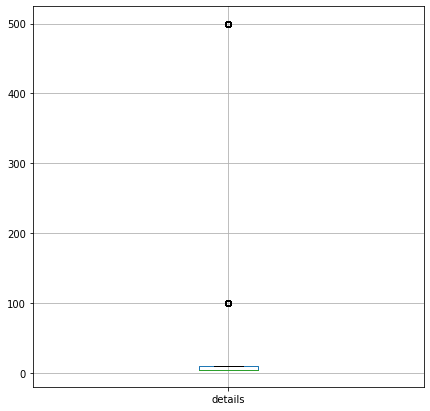

In [31]:
#построим боксплот
ab_events_cleaned.boxplot(column='details', figsize=(7, 7))

*Видим выдающиеся значения в районе 100 и 500.*

In [32]:
#найдем перцентили для покупок
print(np.percentile(ab_events_cleaned.loc[ab_events_cleaned['details'].notnull(), ['details']], [95, 99]))

[ 99.99 499.99]


*Глядя на перецентили видим, что 5 процентов значений о покупках больше 99.99 и 1 процент больше 499.99.*

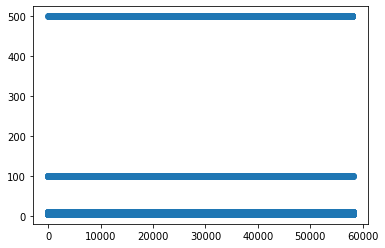

In [33]:
#создаем структуру Series с количеством значений для оси Х
x_values = pd.Series(range(0, len(ab_events_cleaned.loc[ab_events_cleaned['details'].notnull()])))

#строим точечный график
plt.scatter(x_values, ab_events_cleaned.loc[ab_events_cleaned['details'].notnull(), ['details']])

In [34]:
#смотрим на общее количество покупок более 99
len(ab_events_cleaned.query('details > 99'))

6337

*Достаточно большое количество покупок по размеру суммы приходится на выдающиеся значения более 99 - около 6 337. Это почти 10 % информации о покупках. Это могут быть как выбросы, так и категории товаров с достаточно высокой ценой. В задании исследуется конверсия и количество покупок, а не сумма, поэтому эти значения оставляем как есть. Но если требуется найти различия в суммах покупок, то такие значения придется дополнительно изучить и на основании этого принимать решение, что с ними делать.*

### Проверка групп на пересечение и необходимого количества пользователей  

*Создаем списки id пользователей из EU, а также тех, кто принадлежит разным группам теста*

In [35]:
#создаем списки id пользователей из EU
new_users_id_EU = list(ab_new_users_cleaned_EU['user_id'].unique())

#оставляем в датасете с событиями только пользователей из EU
ab_events_cleaned_EU = ab_events_cleaned.query('user_id in @new_users_id_EU').copy()

#оставляем в датасете с группами тестируемых только пользователей из EU
ab_participants_recommender_EU = ab_participants_recommender.query('user_id in @new_users_id_EU').copy()

#составляем список id тех, кто относится к группе А
ab_participants_id_A = list(ab_participants_recommender_EU.query('group == "A"')['user_id'].unique())

#составляем список id тех, кто относится к группе В
ab_participants_id_B = list(ab_participants_recommender_EU.query('group == "B"')['user_id'].unique())

*Создадим датасет, где будут только пользователи, которые совершали события в течение 14 дней с регистрации, и список с именами их ID.*

In [36]:
#добавим столбец с датой в ab_events_cleaned_EU
ab_events_cleaned_EU['date'] = pd.to_datetime(ab_events_cleaned_EU['event_dt'].dt.date)

#создаем датасет с первыми регистрациями пользователей, прошедших тест recommender
ab_new_users_recommender_EU = ab_new_users_cleaned_EU.\
query('user_id in @ab_participants_id_A or user_id in @ab_participants_id_B').copy()

#убираем ненужные колонки
ab_new_users_recommender_EU.drop(columns=['region', 'device'], inplace=True)

#найдем последнюю дату для каждого пользователя (для этого группируем по пользователю ab_events_cleaned_EU)
max_date = ab_events_cleaned_EU.groupby('user_id', as_index=False)['date'].max().\
rename(columns={"date": "max_date"})

#создаем датасет, в котором будет хранится разница между первым и последним действием пользователя
date_difference = ab_new_users_recommender_EU.merge(max_date, how='left', on='user_id')

#заполняем пропуски (пропуски у тех, кто не совершал больше одного события), указывая дату старта теста
date_difference["max_date"] = date_difference["max_date"].fillna('2020-12-07')

#приводим формат столбца к datetime
date_difference["max_date"] = pd.to_datetime(date_difference["max_date"], format='%Y-%m-%d')

#находим разницу между макс. и перв. датой
date_difference['date_difference'] = date_difference['max_date'] - date_difference['first_date']

#делаем срез, где будет только пользователи у которых прошло 14 дней между 1 и последним действием
date_difference_only_14_days = date_difference.query('date_difference <= "14 days"')

#проверяем
date_difference_only_14_days.info()

#делаем список Id для пользователей из date_difference_only_14_days
id_only_14_days = list(date_difference_only_14_days['user_id'].unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6096 entries, 0 to 6350
Data columns (total 4 columns):
user_id            6096 non-null object
first_date         6096 non-null datetime64[ns]
max_date           6096 non-null datetime64[ns]
date_difference    6096 non-null timedelta64[ns]
dtypes: datetime64[ns](2), object(1), timedelta64[ns](1)
memory usage: 238.1+ KB


*Промаркируем пользователей в датасете с событиями на принадлежность к группе А и В.*

In [37]:
#напишем функцию для маркировки к какой группе (А или В) принадлежит пользователь
def ab_marker(data):
    if data['user_id'] in id_only_14_days and data['user_id'] in ab_participants_id_A:
        return 'A'
    elif data['user_id'] in id_only_14_days and data['user_id'] in ab_participants_id_B:
        return 'B'
    else:
        return 'Others'
#добавим столбец с обозначением группы и с датой
ab_events_cleaned_EU['group'] = ab_events_cleaned_EU.apply(ab_marker, axis=1)

#проверяем
display(ab_events_cleaned_EU.head())
display(ab_events_cleaned_EU.info())
display(ab_events_cleaned_EU['group'].value_counts())

,user_id,event_dt,event_name,details,date,group
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,Others
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,Others
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,Others
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,A
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99,2020-12-07,Others


<class 'pandas.core.frame.DataFrame'>
Int64Index: 302653 entries, 1 to 440316
Data columns (total 6 columns):
user_id       302653 non-null object
event_dt      302653 non-null datetime64[ns]
event_name    302653 non-null object
details       44918 non-null float64
date          302653 non-null datetime64[ns]
group         302653 non-null object
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 16.2+ MB


None

Others    281331
A          17105
B           4217
Name: group, dtype: int64

In [38]:
#создаем отдельные датасеты для каждой группы
group_a = ab_events_cleaned_EU.query('group == "A"').copy()
group_b = ab_events_cleaned_EU.query('group == "B"').copy()

#проверяем
display(group_a.head())
display(group_a['group'].value_counts())
print()
display(group_b.head())
display(group_b['group'].value_counts())

,user_id,event_dt,event_name,details,date,group
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,A
17,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,A
93,2F46396B6766CFDB,2020-12-07 13:29:30,purchase,4.99,2020-12-07,A
246,2828E6688DC580C4,2020-12-07 11:43:42,purchase,4.99,2020-12-07,A
287,A1550AF89E314963,2020-12-07 01:22:52,purchase,4.99,2020-12-07,A


A    17105
Name: group, dtype: int64

,user_id,event_dt,event_name,details,date,group
58,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07,B
74,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07,B
118,A9908F62C41613A8,2020-12-07 11:26:47,purchase,9.99,2020-12-07,B
146,0997EC1C4850B27B,2020-12-07 08:01:55,purchase,4.99,2020-12-07,B
155,C7CB2F1BA42F102B,2020-12-07 03:05:05,purchase,99.99,2020-12-07,B


B    4217
Name: group, dtype: int64

In [39]:
#создаем списки id пользователей, которые входили тест. группу B
users_id_group_b = list(group_b['user_id'].unique())

#проверяем на пересечение
len(group_a.query('user_id in@users_id_group_b')['user_id'].unique())

0

*Пересечений не найдено.*

In [40]:
#считаем процент пользователей из региона EU, участвовавших в тесте и у которых прошло 14 дней с регистрации
print("Процент пользователей из EU, принявших участие в тесте: {:.1%}".\
      format(date_difference_only_14_days['user_id'].nunique() / ab_new_users_cleaned_EU['user_id'].nunique()))

Процент пользователей из EU, принявших участие в тесте: 14.4%


In [41]:
#считаем количество пользователей из региона EU, участвовавших в тесте и у которых прошло 14 дней с регистрации
print("Количество пользователей из EU, принявших участие в тесте: {}".\
      format(date_difference_only_14_days['user_id'].nunique()))

Количество пользователей из EU, принявших участие в тесте: 6096


*Видим, что в тесте приняли участие 14.4%, что на 0.6% меньше, чем в задании.*  
*Получили результат - в тесте приняли участие 6 096 пользователь из EU, т.е. задание в этой части соблюдается.*

### Распределение событий по дням

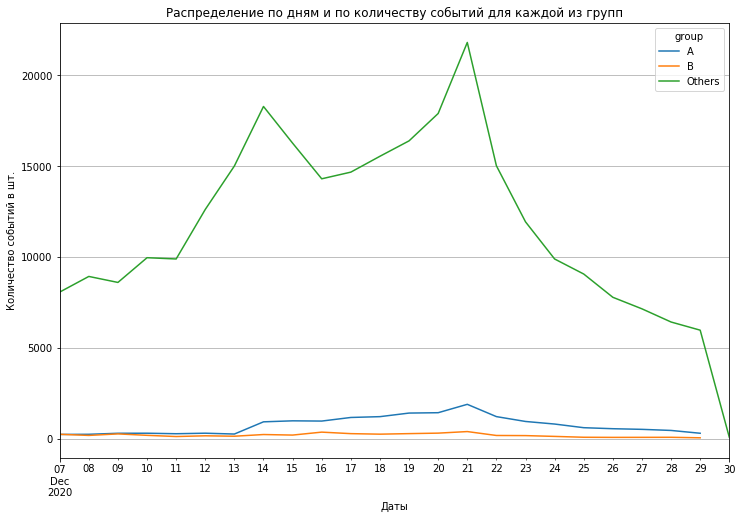

In [42]:
#строим график по дням и по количеству определенных событий
ab_events_cleaned_EU.pivot_table(index='date', columns='group', values='event_name', aggfunc='count').plot(figsize=(12, 8), grid=True)
plt.title('Распределение по дням и по количеству событий для каждой из групп')
plt.ylabel('Количество событий в шт.')
plt.xlabel('Даты')
plt.show()


*На общем графике заметен рост активности пользователей групп А и В в период с 13 по 21 декабря. При этом показатели группы А выше, чем у группы В.*

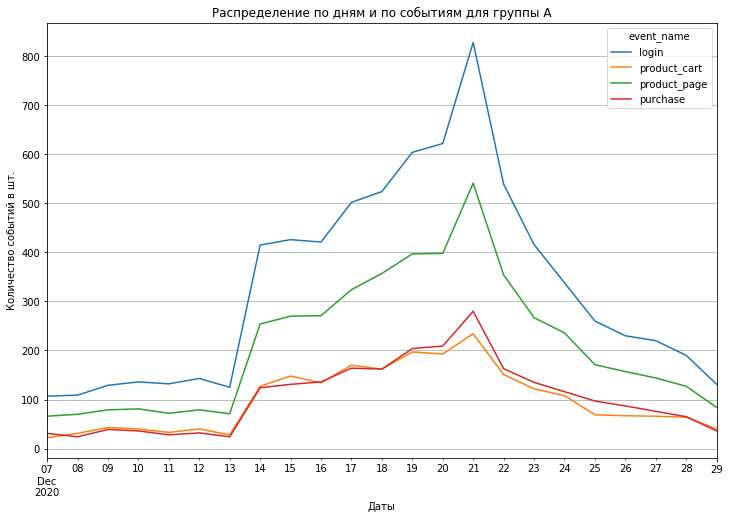

In [43]:
#строим график по дням и по событиям группы А
group_a.pivot_table(index='date', columns='event_name', values='event_dt', aggfunc='count').plot(figsize=(12, 8), grid=True)
plt.title('Распределение по дням и по событиям для группы А')
plt.ylabel('Количество событий в шт.')
plt.xlabel('Даты')
plt.show()

*Для группы А заметно два резких подъема: с 13 по 14 декабря и с 20 по 21 декабря. При этом рост был непрерывным с 16 по 21 декабря. После 21 декабря наблюдается резкий и постоянный спад.*

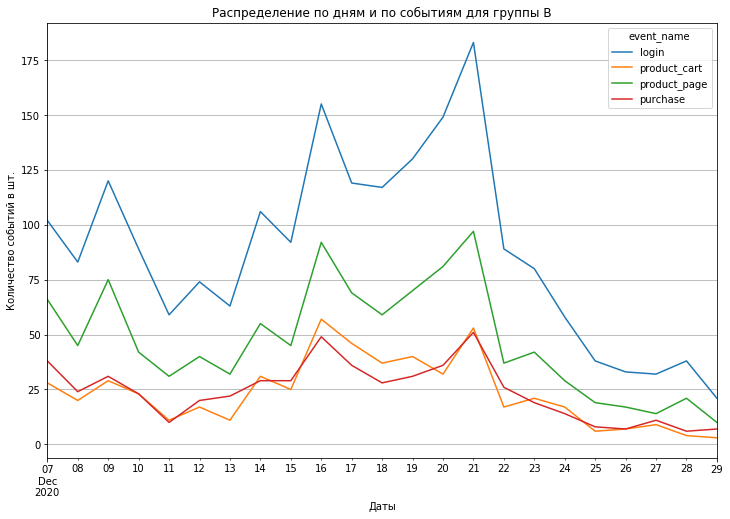

In [44]:
#строим график по дням и по событиям группы В
group_b.pivot_table(index='date', columns='event_name', values='event_dt', aggfunc='count').plot(figsize=(12, 8), grid=True)
plt.title('Распределение по дням и по событиям для группы B')
plt.ylabel('Количество событий в шт.')
plt.xlabel('Даты')
plt.show()

*Для группы В поведение пользователей отличается. График более импульсивный. Видим много пиков и спадов. Самыми заметными являются: с 08 по 09, с 15 на 16 и с 20 на 21. Но после 21 декабря также наблюдается резкий спад. Правда для событий purchase, product cart и product page c 26.12 наблюдается незначительный подъем, который длится 2 дня. По срокам это совпадает с  проводимой акцией, возможно этим и обусловлен подъем.*  
*Судя по всем графикам, можно сделать следующий вывод: 1) на наиболее активный период (13-21 декабря) могло повлиять то, что жители европейской зоны активно совершали покупки перед рождественскими праздниками; 2) действия пользователей из группы В были более импульсивными, чем пользователей из группы А; 3) скорее всего маркетинговое событие Christmas&New Year Promo, которое действовало с  25.12.20 по 03.01.21, могло повлиять на поведение пользователей из группы В в период с 26 по 28 декабря.*

### Построение воронок и нахождение конверсии

In [45]:
#создадим датасет, напротив каждого пользователя будет название группы
users_14_days_with_groups = date_difference_only_14_days.merge(ab_participants_recommender_EU, how='left', on='user_id')

In [46]:
#построим воронку для группы А
funnel_A = group_a.groupby('event_name', as_index=False).agg({'user_id': 'nunique'}).\
rename(columns={"user_id": "users_number"})

#добавим в датафрейм данные по регистрациям, как 1 этап воронки
funnel_A.loc[4] = ['registrations', len(users_14_days_with_groups.query('group == "A"'))]

#найдем долю
funnel_A['ratio'] = round(funnel_A['users_number'] / len(users_14_days_with_groups.query('group == "A"')), 2)

display(funnel_A.sort_values(by='users_number', ascending=False))

,event_name,users_number,ratio
4,registrations,3488,1.00
0,login,2458,0.70
2,product_page,1590,0.46
3,purchase,798,0.23
1,product_cart,748,0.21


In [47]:
#построим воронку для группы B
funnel_B = group_b.groupby('event_name', as_index=False).agg({'user_id': 'nunique'}).\
rename(columns={"user_id": "users_number"})

#добавим в датафрейм данные по регистрациям, как 1 этап воронки
funnel_B.loc[4] = ['registrations', len(users_14_days_with_groups.query('group == "B"'))]

#найдем долю
funnel_B['ratio'] = round(funnel_B['users_number'] / len(users_14_days_with_groups.query('group == "B"')), 2)

display(funnel_B.sort_values(by='users_number', ascending=False))

,event_name,users_number,ratio
4,registrations,2608,1.00
0,login,768,0.29
2,product_page,432,0.17
3,purchase,220,0.08
1,product_cart,218,0.08


*1. Если отталкиваться от значений воронок, то конверсия на каждом шаге воронки для теста В хуже, чем у группы А: доля product_page на 30 меньше, purchase - на 15, product_cart - на 13.*  
*2. Кроме этого, количество покупок - последний шаг обеих воронок, превышает количество событий на предпоследнем шаге - добавление в корзину. Вероятно это обусловлено тем, что товар приобретался сразу, минуя корзину.*

In [48]:
#посмотрим сколько всего участников в группе А и В
print("Всего участников в группе В и А", int(funnel_B.loc[4, 'users_number'] + funnel_A.loc[4, 'users_number']))

Всего участников в группе В и А 6096


In [49]:
#посмотрим сколько приходится событий на 1 одного пользователя в группе
print("Событий на 1 пользователя в группе А:", int(len(group_a) / funnel_A.loc[4, 'users_number']))
print("Событий на 1 пользователя в группе B:", int(len(group_b) / funnel_B.loc[4, 'users_number']))

Событий на 1 пользователя в группе А: 4
Событий на 1 пользователя в группе B: 1


*Всего участников в группах А и В - 6096, при этом на каждого пользователя в группе А приходится по 4 события, а на участников из группы В по 1 событию.*

### Выводы к шагу 2
1. Наблюдения по распределению событий: 1) наиболее активный период для пользователей 13-21 декабря, на который могло повлиять то, что жители европейской зоны активно совершали покупки перед рождественскими праздниками; 2) действия пользователей из группы В были более импульсивными, чем пользователей из группы А; 3) скорее всего маркетинговое событие Christmas&New Year Promo, которое действовало с  25.12.20 по 03.01.21, могло в какой-то степени повлиять на поведение пользователей из группы В в период с 26 по 28 декабря.
2. Окончание периода теста приходилось на новогодние праздники. Возможно по этому в группе В активность пользователей к 30.12 была около 0. 
3. По заданию набор пользователей должен был быть остановлен 21.12.20, но в данных были пользователи, зарегистрировавшиеся 23.12.20. Поэтому такие пользователи были исключены из анализа.
4. В данных было обнаружено, что часть пользователей участвовала в тесте interface_eu_test (1 602 пользователя).
5. В тесте приняли участие 14.4% из EU, что на 06.% меньше, чем в задании. Всего участвовал 6 096 пользователь из EU, т.е. задание в этой части соблюдено.
6. Всего участников в группах А и В - 6096, при этом на каждого пользователя в группе А приходится по 4 события, а на участников из группы В по 1 событию.
7. Конверсия на каждом шаге воронки для теста В хуже, чем у группы А: доля product_page на 30 меньше, purchase - на 15, product_cart - на 13. Кроме этого, количество покупок - последний шаг обеих воронок, превышает количество событий на предпоследнем шаге - добавление в корзину. Вероятно это обусловлено тем, что товар приобретался сразу, минуя корзину.
8. Достаточно большое количество покупок по размеру суммы приходится на выдающиеся значения более 99 - около 6 337. Это почти 10 % информации о покупках. Это могут быть как выбросы, так и категории товаров с достаточно высокой ценой. В задании исследуется конверсия и количество покупок, а не сумма, поэтому эти значения оставляем как есть. Но если требуется найти различия в суммах покупок, то такие значения придется дополнительно изучить и на основании этого принимать решение, что с ними делать.
9. Пересечения в группах по тесту recommender_system_test отсутствуют.

 <a id="results_checking"></a>
## Оценка результатов А/В-теста

*Формулируем гипотезы:*  

*1. Нулевая гипотеза (Н0) - статистически значимых различий в долях групп А и В нет.*  
*2. Альтернативная гипотеза (Н1) - статистически значимые различия между долями в группах А и В имеются.*

In [50]:
#создадим функцию для расчета стат. значимости
def stat_sign(success_1, success_2, trial_1, trial_2):
    # критический уровень статистической значимости
    alpha = 0.05 

    successes = np.array([success_1, success_2])
    trials = np.array([trial_1, trial_2])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    #пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    #разница пропорций в датасетах
    difference = p1 - p2 

    #считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.'
        ) 

*Смотрим на стат. значимость в долях для product_page*

In [51]:
#вызываем функцию для product_page
stat_sign(funnel_A.loc[2, 'users_number'], funnel_B.loc[2, 'users_number'], funnel_A.loc[4, 'users_number'], funnel_B.loc[4, 'users_number'])

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [52]:
print('Доля product_page группы А равна:', funnel_A.loc[2, 'ratio'])
print('Доля product_page группы B равна:', funnel_B.loc[2, 'ratio'])

Доля product_page группы А равна: 0.46
Доля product_page группы B равна: 0.17


*Смотрим на стат. значимость в долях для product_cart*

In [53]:
#вызываем функцию для product_cart
stat_sign(funnel_A.loc[1, 'users_number'], funnel_B.loc[1, 'users_number'], funnel_A.loc[4, 'users_number'], funnel_B.loc[4, 'users_number'])

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [54]:
print('Доля product_cart группы А равна:', funnel_A.loc[1, 'ratio'])
print('Доля product_cart группы B равна:', funnel_B.loc[1, 'ratio'])

Доля product_cart группы А равна: 0.21
Доля product_cart группы B равна: 0.08


*Смотрим на стат. значимость в долях для purchase*

In [55]:
#вызываем функцию для purchase
stat_sign(funnel_A.loc[3, 'users_number'], funnel_B.loc[3, 'users_number'], funnel_A.loc[4, 'users_number'], funnel_B.loc[4, 'users_number'])

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [56]:
print('Доля purchase группы А равна:', funnel_A.loc[3, 'ratio'])
print('Доля purchase группы B равна:', funnel_B.loc[3, 'ratio'])

Доля purchase группы А равна: 0.23
Доля purchase группы B равна: 0.08


*Уровень статистической значимости взят в размере 0.05*  
*Проверка статистических гипотез показала, что между долями в группах А и В есть статистически значимые различия.*


<a id="summary"></a>
## Общие выводы

1. Наблюдения по распределению событий: 1) наиболее активный период для пользователей 13-21 декабря, на который могло повлиять то, что жители европейской зоны активно совершали покупки перед рождественскими праздниками; 2) действия пользователей из группы В были более импульсивными, чем пользователей из группы А; 3) скорее всего маркетинговое событие Christmas&New Year Promo, которое действовало с  25.12.20 по 03.01.21, могло повлиять на поведение пользователей из группы В в период с 26 по 28 декабря.
2. Окончание периода теста приходилось на новогодние праздники. Возможно по этому в группе В активность пользователей к 30.12 была около 0. 
3. По заданию набор пользователей должен был быть остановлен 21.12.20, но в данных были пользователи, зарегистрировавшиеся 23.12.20. Поэтому такие пользователи были исключены из анализа.
4. В данных было обнаружено, что часть пользователей участвовала в тесте interface_eu_test (1 602 пользователя).
5. В тесте приняли участие 14.4% из EU, что на 06.% меньше, чем в задании. Всего участвовал 6 096 пользователь из EU, т.е. задание в этой части соблюдено.
6. Всего участников в группах А и В - 6096, при этом на каждого пользователя в группе А приходится по 4 события, а на участников из группы В по 1 событию.
7. Конверсия на каждом шаге воронки для теста В хуже, чем у группы А: доля product_page на 30 меньше, purchase - на 15, product_cart - на 13. Кроме этого, количество покупок - последний шаг обеих воронок, превышает количество событий на предпоследнем шаге - добавление в корзину. Вероятно это обусловлено тем, что товар приобретался сразу, минуя корзину.
8. Достаточно большое количество покупок по размеру суммы приходится на выдающиеся значения более 99 - около 6 337. Это почти 10 % информации о покупках. Это могут быть как выбросы, так и категории товаров с достаточно высокой ценой. В задании исследуется конверсия и количество покупок, а не сумма, поэтому эти значения оставляем как есть. Но если требуется найти различия в суммах покупок, то такие значения придется дополнительно изучить и на основании этого принимать решение, что с ними делать.
9. Пересечений в группах по тесту recommender_system_test не найдено.
10. Проверка статистических гипотез показала, что между долями в группах А и В есть статистически значимые различия.

**Требования тех. задания были учтены при проверке, пересечения в группах отсутствовали. Вместе с тем, следует отметить, что часть требований тех. задания не была соблюдена: доля пользователей из EU составила чуть менее 15% (14.4%), маркетинговое событие Christmas&New Year могло незначительно повлиять на поведение пользователей (немного заметно по группе В). Но при этом, в показателях конверсии группа А значительно лучше показателей группы В, что подтверждено и стат. тестами. Поэтому можно сказать, что измененную рекомендательную систему внедрять не следует.**